In [ ]:
# System packages
import os
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 
import pprint as pp


# sklearn 

# sklearn tools 
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import accuracy_score
import scikitplot.plotters as skplt

# nlp
from gensim.models import KeyedVectors

# models
import xgboost as xgb
import eli5
from eli5.explain import explain_weights
from eli5.formatters import explain_weights_df

warnings.filterwarnings('ignore')

In [ ]:
# Add utils_functions.py as a dataset
# Import module 
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/utils-functions/utils_functions.py", dst = '/kaggle/working/utils_functions.py')
from utils_functions import *

## 1. Load data 

In [ ]:
df = pd.read_csv('../input/processed/train_variants_text.csv')
df=df.dropna(subset=['Text'])

### Process data

In [283]:
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    ('converter',Converter()),
    ('countvector', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words))
                        
])


Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
    ('converter',Converter()),
    ('countvector', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words))
                        
])

Text = Pipeline([
    ('selector',ItemSelector(key="Text")),
    ('converter',Converter()),
    #('countvector', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
    ('tfidf', TfidfVectorizer())
    
])



In [279]:
df['Class'] = df['Class'].astype(int)
df['Gene'] = df['Gene'].astype(str)
df['Variation'] = df['Variation'].astype(str)

y= df['Class']
X= df.drop(['Class','ID'],axis =1)


## 3.1 Three features + Keras Model

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [192]:
all_size=X.shape[0]
all_size

3316

In [194]:
from scipy.sparse import hstack
Variation_vector = Variation.fit_transform(X)
print(Variation_vector.shape)
Gene_vector = Variation.fit_transform(X)
print(Gene_vector.shape)
Text_vector=  Text.fit_transform(X)
print(Text_vector.shape)
stack_vect = hstack((Variation_vector[:all_size],\
                     Gene_vector[:all_size],\
                     Text_vector[:all_size]))


stack_csr =stack_vect.tocsr() # https://www.kaggle.com/c/quora-question-pairs/discussion/33491

(3316, 256)
(3316, 256)
(3316, 155732)


In [278]:
print(stack_vect.shape)
stack_shape = stack_csr.shape[1]

(3316, 156244)


### Use featureUnion

In [277]:
feature_pipe = Pipeline([
    ('features',FeatureUnion([
        ('Variation',Variation),
        ('Gene',Gene),
        ('Text',Text)
    ]))
    
])
features = feature_pipe.fit_transform(X)
features.shape

(3316, 156187)

In [282]:
features_csr = features.tocsr() 
print(features_csr.shape)

(3316, 156187)


In [201]:
from keras.optimizers import SGD
def baseline_model():
    model = Sequential()
    model.add(Dense(256,input_shape=(int(stack_shape),)))
    #model.add(Dense(input_dim, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [198]:
stack_csr =stack_vect.tocsr() 
print(stack_csr.shape)
print(type(stack_csr))

(3316, 156244)
<class 'scipy.sparse.csr.csr_matrix'>


In [284]:
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=baseline_model)#,epochs=5,verbose=0

In [207]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y)
encoded_y = np_utils.to_categorical((label_encoder.transform(y)))
print(encoded_y.shape)

(3316, 9)


In [208]:
estimator=clf.fit(stack_csr, encoded_y, validation_split=0.1, epochs=5, batch_size=32)

Train on 2984 samples, validate on 332 samples
Epoch 1/5
2984/2984 [==============================] - 35s 12ms/step - loss: 2.0048 - acc: 0.2661 - val_loss: 1.7804 - val_acc: 0.4608
Epoch 2/5
2984/2984 [==============================] - 32s 11ms/step - loss: 1.8640 - acc: 0.2678 - val_loss: 1.7244 - val_acc: 0.4608
Epoch 3/5
2984/2984 [==============================] - 33s 11ms/step - loss: 1.8470 - acc: 0.2678 - val_loss: 1.7146 - val_acc: 0.4608
Epoch 4/5
2984/2984 [==============================] - 32s 11ms/step - loss: 1.8373 - acc: 0.2678 - val_loss: 1.7180 - val_acc: 0.4789
Epoch 5/5
2984/2984 [==============================] - 32s 11ms/step - loss: 1.8149 - acc: 0.2949 - val_loss: 1.6209 - val_acc: 0.5000


In [268]:
# Check history
history = estimator.history
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)
# Save history in a csv file
name = '{}{:%Y%m%dT%H%M%S}.csv'.format(('full_kaggle_kears'), datetime.datetime.now())
Run1_history= pd.DataFrame(history, index=epochs)
Run1_history.to_csv(name)
print(Run1_history.head)

<bound method NDFrame.head of    val_loss   val_acc      loss       acc
1  1.780380  0.460843  2.004760  0.266086
2  1.724354  0.460843  1.863954  0.267761
3  1.714550  0.460843  1.846970  0.267761
4  1.718020  0.478916  1.837266  0.267761
5  1.620857  0.500000  1.814929  0.294906>


In [270]:
from keras.callbacks import ModelCheckpoint
weightsname = '{}{:%Y%m%dT%H%M%S}.hd5'.format(('full_kaggle_kears'), datetime.datetime.now())

checkpointer = ModelCheckpoint(filepath=weightsname, verbose=1, save_best_only=True)


In [224]:
estimator3=clf.fit(stack_csr, encoded_y, validation_split=0.1, epochs=10, \
                   batch_size=32, verbose=5, callbacks=[checkpointer,history])

Train on 2984 samples, validate on 332 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.79181, saving model to /tmp/weights.hdf5
Epoch 2/10

Epoch 00002: val_loss improved from 1.79181 to 1.73006, saving model to /tmp/weights.hdf5
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.73006
Epoch 4/10

Epoch 00004: val_loss improved from 1.73006 to 1.67258, saving model to /tmp/weights.hdf5
Epoch 5/10

Epoch 00005: val_loss improved from 1.67258 to 1.63596, saving model to /tmp/weights.hdf5
Epoch 6/10

Epoch 00006: val_loss improved from 1.63596 to 1.58191, saving model to /tmp/weights.hdf5
Epoch 7/10

Epoch 00007: val_loss improved from 1.58191 to 1.37945, saving model to /tmp/weights.hdf5
Epoch 8/10

Epoch 00008: val_loss improved from 1.37945 to 1.33062, saving model to /tmp/weights.hdf5
Epoch 9/10

Epoch 00009: val_loss improved from 1.33062 to 1.32690, saving model to /tmp/weights.hdf5
Epoch 10/10

Epoch 00010: val_loss did not improve from 1.32690


In [257]:
import matplotlib.pyplot as plt

def plot_history(estimator):
    fig = plt.figure(figsize=(5,5))
    #plt.subplot(121)
    plt.plot(estimator.history['acc'])
    plt.plot(estimator.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

# summarize history for loss
    #plt.subplot(122)
    fig = plt.figure(figsize=(5,5))
    plt.plot(estimator.history['loss'])
    plt.plot(estimator.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('full_kaggle_kears'), datetime.datetime.now())
    fig.savefig(figname,figdpi = 600)
    plt.close()
    

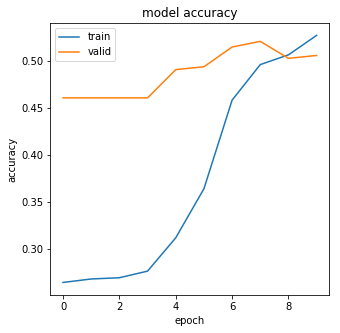

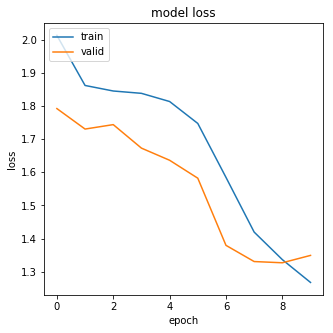

In [285]:
plot_history(estimator3)

In [288]:
from keras.optimizers import SGD
def feature_union_model():
    model = Sequential()
    model.add(Dense(256,input_shape=(int(features_csr.shape[1]),)))
    #model.add(Dense(input_dim, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

In [289]:
from keras.wrappers.scikit_learn import KerasRegressor
clf4 = KerasRegressor(build_fn=feature_union_model)#,epochs=5,verbose=0

In [292]:
estimator4=clf4.fit(features_csr, encoded_y, validation_split=0.1, epochs=2, \
                   batch_size=32, verbose=5, callbacks=[checkpointer])

Train on 2984 samples, validate on 332 samples
Epoch 1/2

Epoch 00001: val_loss improved from inf to 1.76953, saving model to full_kaggle_kears20190613T102034.hd5
Epoch 2/2

Epoch 00002: val_loss improved from 1.76953 to 1.70898, saving model to full_kaggle_kears20190613T102034.hd5


## 3.1 Bag-of-words 1 Group+xgboost

### Split into Train amd Validation data

In [ ]:
X_tr, X_val, y_tr, y_val = split_data(df,
                                      'Text',
                                      'Class',
                                      0.1,
                                      0,
                                      stratify='Class')

In [ ]:
clf = Pipeline([('vect', CountVectorizer(preprocessor=clean_text_stemmed, stop_words =stop_words)),
                ('tfidf', TfidfTransformer()),
                ('clf',  xgb.XGBClassifier(objective="multi:softprob", random_state=42))])                           

In [ ]:
clf.fit(X_tr, y_tr)  
predicted = clf.predict(X_val)
acc=np.mean(predicted == y_val)
print(acc)

In [ ]:
X_te = test.Text.values
X_te.shape

In [ ]:
y_te = clf.predict_proba(X_te)
y_te.shape

In [ ]:
submission_df = pd.DataFrame(y_te, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.1_new.csv', index=False)

## 3.2 Bag-of-words *3 groups +xgboost

In [ ]:
# Select one dataframe column for vectorization
def build_preprocessor(df,field):
    field_idx = list(df.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
default_preprocessor = CountVectorizer().build_preprocessor()    

In [ ]:
vectorizer = FeatureUnion([
    ('Variation',TfidfVectorizer(preprocessor=build_preprocessor(X,'Variation'))),
        ('Gene',TfidfVectorizer(preprocessor=build_preprocessor(X,'Gene'))),
        ('Text',TfidfVectorizer(preprocessor=build_preprocessor(X,'Text'))),
])

In [ ]:
X_v = vectorizer.fit_transform(X.values)
X_tr, X_val, y_tr, y_val = train_test_split(X_v,
                                            y,
                                            test_size=0.2,
                                            stratify=y,
                                            random_state=42)

In [ ]:
model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
model.fit(X_tr, y_tr)

In [ ]:
# Accuracy score 
model.score(X_val,y_val)

In [ ]:
df_name = explain_weights_df(model, vec=vectorizer, top=10, feature_filter=lambda x: x != '<BIAS>')
                
df_name.to_csv('../data/features/20190609full_union_3groups_tfidf_feature_weights.csv')

df_name.head(10)

In [ ]:
# Analyzing individual predictions. Let's check some predictions from the validation set. You see a summary of various vectorizer's contribution at the top, and then below you can see features highlighed in text.
eli5.show_prediction(model, doc=X.values[1], vec=vectorizer)

### Do a kaggle submission 

In [ ]:
# Stage 2 test data
df_test = pd.read_csv('../data/processed/stage2_test_variants_text.csv')
test =df_test.drop(['ID'],axis =1)
test['Gene'] = test['Gene'].astype(str)
test['Variation'] = test['Variation'].astype(str)
test['Text'] = test['Text'].astype(str)
test.head(1)

X_te = vectorizer.transform(test.values)
y_te = model.predict(X_te)
y_te.shape

y_pro = model.predict_proba(X_te)
submission_df = pd.DataFrame(y_pro, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.2.csv', index=False)

### Prepare submission file

In [ ]:
y_pro = model.predict_proba(X_te)
submission_df = pd.DataFrame(y_pro, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.2.csv', index=False)

## 3.3 Doc2Vec

In [ ]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
df['Text'] = df['Text'].apply(clean_text_stemmed)

In [ ]:
X_tr, X_val, y_tr, y_val = split_data(df,
                                      'Text',
                                      'Class',
                                      0.1,
                                      0,
                                      stratify='Class')

In [ ]:
X_train = label_sentences(X_tr, 'Train')
X_validation = label_sentences(X_val, 'Test')
all_data = X_train + X_validation 
print(len(all_data))

In [ ]:
all_data[:1]

In [ ]:
from tqdm import tqdm
from sklearn import utils
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
val_vectors_dbow = get_vectors(model_dbow, len(X_validation), 300, 'Test')

In [ ]:
clf =xgb.XGBClassifier(objective="multi:softprob", random_state=42)

In [ ]:
clf.fit(train_vectors_dbow, y_tr)  

In [ ]:
clf.score(val_vectors_dbow, y_val)

In [ ]:
predicted = clf.predict_proba(val_vectors_dbow)
predicted[0]


In [ ]:
model_dbow.save('model_dbow_doc2vec')
#model_dbow = Doc2Vec.load('d2v_model_dm.doc2vec')
#model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
from sklearn.model_selection import cross_val_score
# Performing K fold Cross Validation to get an estimate of model performance on unknown data.
print('Doc2Vec + XGBoost Mean score: {}'.format(cross_val_score(estimator=clf, 
                                                                  X=train_vectors_dbow, y= y_tr,
                                                                  cv=3, n_jobs = -1).mean()))

In [ ]:
os.listdir('../input/msk-redefining-cancer-treatment')

In [ ]:
# Stage 2 Submission test file
test_v = pd.read_csv('../input/msk-redefining-cancer-treatment/stage2_test_variants.csv')
print('1) test_variants:') 
print(test_v.head(2))
print(' ')


# Test Text
test_t = pd.read_csv('../input/msk-redefining-cancer-treatment/stage2_test_text.csv', sep='\|\|', header=None, skiprows=1, \
                      names=["ID","Text"],engine='python')
print('2) test_text:') 
print(test_t.head(2))
print(' ')


In [ ]:

# Merge test variants and text by unique ID
print('2) Merge test text variants and text')
test = pd.merge(test_v,test_t,on='ID',how='left')
print(test.head(2))

test.to_csv('../input/stage2_test_variants_text.csv',index=False)

In [ ]:
# Stage 2 test data
df_test = pd.read_csv('../input/stage2_test_variants_text.csv')
test =df_test.drop(['ID'],axis =1)
test['Gene'] = test['Gene'].astype(str)
test['Variation'] = test['Variation'].astype(str)
test['Text'] = test['Text'].astype(str)
test.head(1)


In [ ]:
test['Text'] = test['Text'].apply(clean_text_stemmed)

In [ ]:
test.to_csv('stage2_test_variants_text_clean_stemmed.csv',index=False)

In [ ]:
X_te= test['Text']

In [ ]:
X_test = label_sentences(X_te, 'Test')


In [ ]:
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')


In [ ]:
y_test = clf.predict_proba(test_vectors_dbow)

In [ ]:
submission_df = pd.DataFrame(y_pro, columns=['class'+str(c+1) for c in range(9)])

submission_df['ID'] = df_test['ID']
submission_df.head()

mysubset = ["ID"]
mask = submission_df.columns.isin(mysubset)
submission_df =pd.concat([submission_df.loc[:,mask], submission_df.loc[:,~mask]], axis=1)
submission_df.to_csv('../data/processed/stage2_submission_3.3.csv', index=False)